# <center>Credit Card Fraud Detection<center/> 

![](https://militaryguide.com/wp-content/uploads/2013/01/Credit-Card-Fraud.jpg)

<a id="INDEX"></a>

- [I. Introduction](#Introduction)


- [II. Retrieving the Data](#Retrieving the Data)
   -  Function to retrieve a column description
   -  Function to compute the percents of target's distribution


- [III. UNDERSTANDING THE DATA](#UNDERSTANDING)
   -  [1. Upstream inspection](#UPSTREAM-INSPECTION)
   -  [2. Data's balance](#BALANCE)
   -  [3. Special Features: time and amount](#SPECIAL-FEATURES)


- [IV. PREPROCESSING](#PREPROCESSING)
   -  [1. Scaling](#SCALING)
   -  [2. Splitting the data](#SPLITTING-DATA)


- [V. PREDICTION APPROACHES](#PREDICTION APPROACHES)
   -  [1. Distributing and correlating](#DIST-COR)
   -  [2. Anomaly detection](#ANOMALY-DETECTION)
       - [1. Forest](#Forest)
   -  [3. Dimensionality Reduction and Clustering](#DIM-CLUSTER)
   -  [4. Classifiers](#CLASSIFIERS)
   -  [5. Conclusion](#CONCLUSION)
   -  [6. Oversampling](#OVERSAMPLING)


- [VI. MODEL TRAINING](#MODEL-TRAINING)


- [VII. RESULTS](#RESULTS)

# <a id='1'>I. Introduction</a>

# Description
Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.
Content

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
Inspiration

Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.
Acknowledgements

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

## DataSet :

The dataset that is used for credit card fraud detection is derived from the following Kaggle URL :

https://www.kaggle.com/mlg-ulb/creditcardfraud

### Let's import libraries first:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
LABELS = ["Normal", "Fraud"]
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

! ls

# <a id='2'>2. Retrieving the Data</a>

### Let's check what our data looks like:

In [10]:
credit = pd.read_csv('/home/wafa/Bureau/creditcardfraud/creditcard.csv')
credit.head()
print(credit.shape)

(284807, 31)


In [36]:
# explore the dataset
print(credit.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


# <a id='3'>3. Data Exploration</a>

### Next, let's check if our dataset contains any null variables or duplicates:

In [37]:
#credit.isnull().sum()
credit.duplicated().sum()

1081

In [11]:
credit = credit.drop_duplicates()

In [39]:
credit.duplicated().sum()

0

In [40]:
print(credit.shape)
credit.describe()

(283726, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


# Visualizing Dataset

### In order to check how skewed our data is, let's check for the percentage of each class:

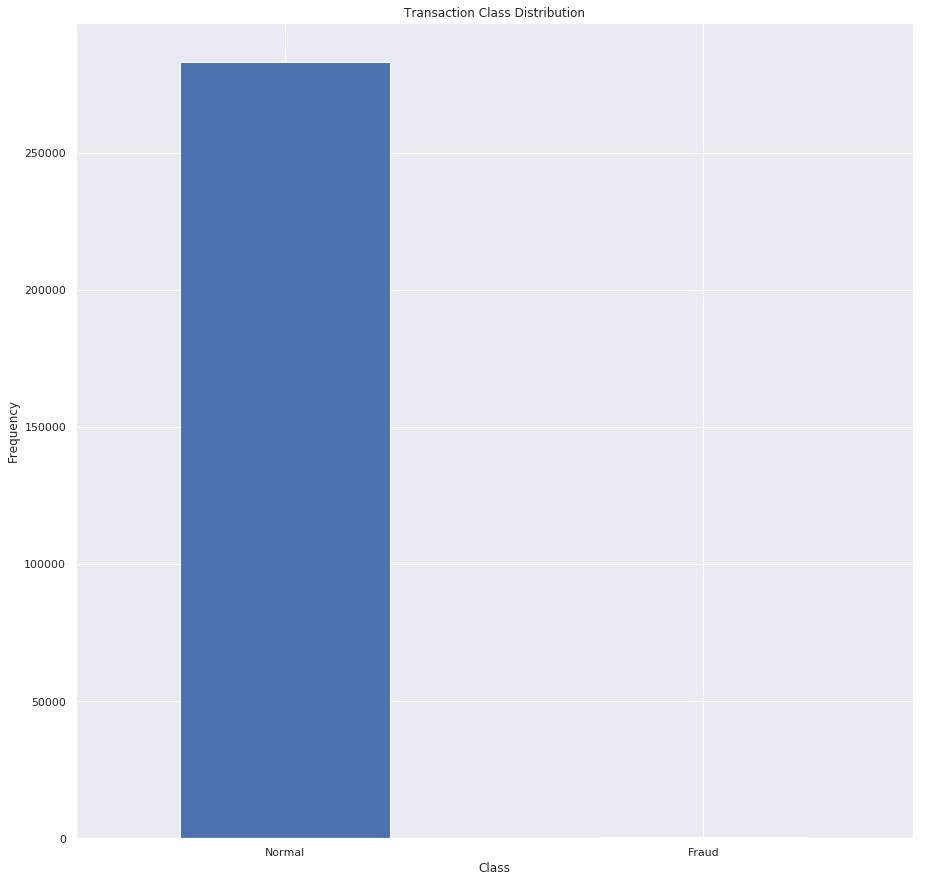

In [58]:
plt.figure(figsize=(15,15))
count_classes = pd.value_counts(credit['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");




In [72]:
# Check ratio between classes
percentage_fraud = round((credit['Class'].value_counts()[1] / len (credit)) * 100, 2)
percentage_no_fraud = round((credit['Class'].value_counts()[0] / len(credit)) * 100, 2)

print ('Percentage Fraud transactions: ', percentage_fraud)
print ('Percentage No-fraud transactions: ', percentage_no_fraud)

Percentage Fraud transactions:  0.17
Percentage No-fraud transactions:  99.83


##### Fraud-transactions occupy only 0.17% of the dataset, this dataset is heavily skewed.

In [4]:
# Determine number of fraud cases in dataset

Fraud = credit[credit['Class'] == 1]
Valid = credit[credit['Class'] == 0]

print('Fraud Cases: {}'.format(len(credit[credit['Class'] == 1])))
print('Valid Transactions: {}'.format(len(credit[credit['Class'] == 0])))

Fraud Cases: 473
Valid Transactions: 283253


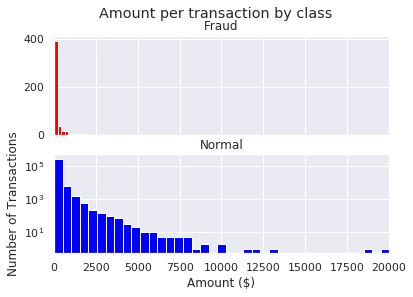

In [46]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(Fraud.Amount, bins =10, color='red')
ax1.set_title('Fraud')
ax2.hist(Valid.Amount, bins = bins, color= 'blue')
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

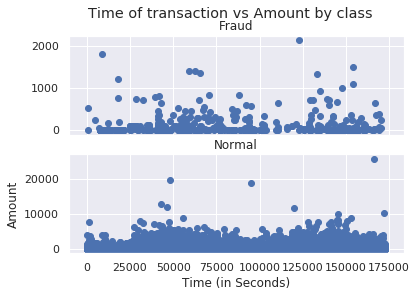

In [47]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(Fraud.Time, Fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(Valid.Time, Valid.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()


In [48]:
init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

In [49]:
# Create a trace

trace = go.Scatter(
    x = Fraud.Time,
    y = Fraud.Amount,
    mode = 'markers'
)
data = [trace]

In [50]:
plotly.offline.iplot({
    "data": data
})

## Observations

The data set is highly skewed, consisting of 492 frauds in a total of 284,807 observations. This resulted in only 0.172% fraud cases. This skewed set is justified by the low number of fraudulent transactions.

The dataset consists of numerical values from the 28 ‘Principal Component Analysis (PCA)’ transformed features, namely V1 to V28. Furthermore, there is no metadata about the original features provided, so pre-analysis or feature study could not be done.

The ‘Time’ and ‘Amount’ features are not transformed data.

There is no missing value in the dataset.



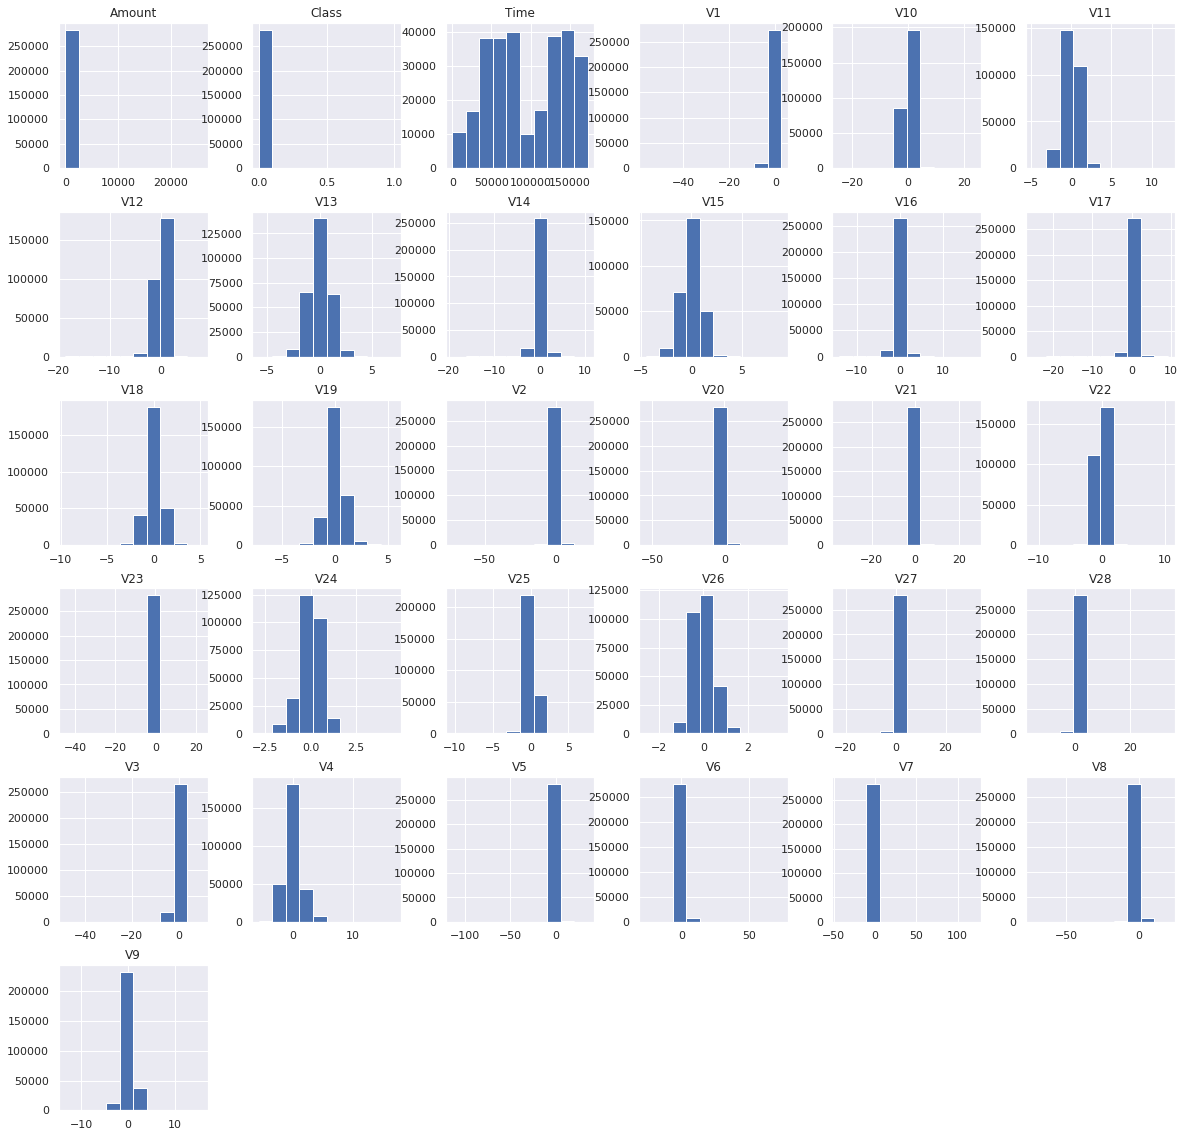

In [12]:
# Plot histograms of each parameter 
credit.hist(figsize = (20, 20))
plt.show()

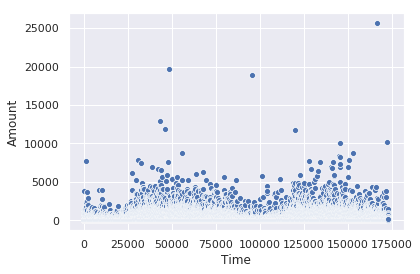

In [13]:
sns.scatterplot(credit['Time'], credit['Amount'])
plt.show()

- The anonymized predictors are already transformed with PCA
- Two predictors 'Amount' and 'Time' has not been scaled yet. 
- So we need to normalize these features also.

In [12]:
credit['Time_day'] = credit['Time'].apply(lambda x : x/ 3600 %24)

Text(0.5,0.98,'Categorical Plotting')

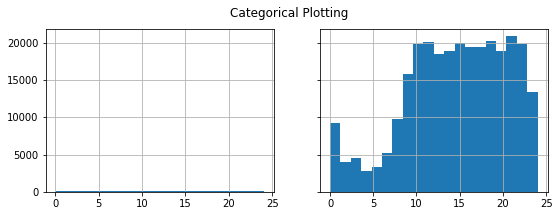

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)

Fraud = credit[credit["Class"]==1]
Fraud["Time_day"].hist(ax = axs[0], bins = 5)

Valid = credit[credit["Class"]==0]
Valid["Time_day"].hist(ax = axs[1], bins = 20)
#plt.show()

fig.suptitle('Categorical Plotting')

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler

rob_scaler = RobustScaler()

credit['scaled_amount'] = rob_scaler.fit_transform(credit['Amount'].values.reshape(-1,1))
credit['scaled_time'] = rob_scaler.fit_transform(credit['Time'].values.reshape(-1,1))

# Let's look at the data again !
credit.drop(['Time'], axis =1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Amount,Class,Time_day,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000,1.774718,-0.995290
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000,-0.268530,-0.995290
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000278,4.959811,-0.995279
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000278,1.411487,-0.995279
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000556,0.667362,-0.995267
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0,0.000556,-0.254902,-0.995267
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0,0.001111,-0.236546,-0.995243
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0,0.001944,0.261438,-0.995208
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0,0.001944,0.990127,-0.995208
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0,0.002500,-0.254763,-0.995185


Text(0.5,0.98,'Categorical Plotting')

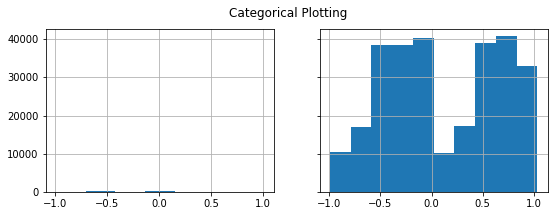

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)

Fraud = credit[credit["Class"]==1]
Fraud["scaled_time"].hist(ax = axs[0], bins = 7)

Valid = credit[credit["Class"]==0]
Valid["scaled_time"].hist(ax = axs[1], bins = 10)
#plt.show()

fig.suptitle('Categorical Plotting')

# <a id='4'>4. Resampling Techniques</a>

In [24]:
X = credit.drop ('Class', axis = 1)
y = credit['Class']

from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((198608, 33), (85118, 33), (198608,), (85118,))

In [25]:
X_train_valid = X_train[y_train==0]
X_train_valid.shape

(198277, 33)

In [26]:
y_train_valid = y_train[y_train==0]
y_train_valid.shape

(198277,)

In [27]:
X_test_valid = X_test[y_test==0]
X_test_valid.shape

(84976, 33)

In [28]:
y_test_valid = y_test[y_test==0]
y_test_valid.shape

(84976,)

!pip install imbalanced-learn

In [14]:
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(X_train, y_train)

X_res, y_res

(array([[ 3.83820000e+04, -8.66903328e-01,  1.01852625e+00, ...,
          1.06616667e+01,  2.08594076e-01, -5.44232357e-01],
        [ 1.38806000e+05,  2.18906914e+00, -9.87986622e-01, ...,
          1.45572222e+01, -1.25156446e-01,  6.35931757e-01],
        [ 1.63459000e+05, -3.79814291e-01, -1.52088005e-01, ...,
          2.14052778e+01,  1.30718954e+00,  9.25649214e-01],
        ...,
        [ 6.15776172e+04, -4.76852332e+00,  7.91363077e-02, ...,
          1.71048937e+01,  1.36504485e+01, -2.71641791e-01],
        [ 2.51936556e+04, -1.02662832e+01,  7.22150743e+00, ...,
          6.99823765e+00,  5.73292020e-01, -6.99219321e-01],
        [ 1.66127470e+05, -2.04855354e+00, -5.86232646e-01, ...,
          2.21465195e+01, -7.43504972e-02,  9.57008576e-01]]),
 array([0, 0, 0, ..., 1, 1, 1]))

# <a id='5'>5. Model Prediction</a>

In [15]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_res, y_res)
y_score = lr.predict_proba(X_test)

/home/wafa/bin/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [16]:
from sklearn.metrics import precision_recall_curve, auc
precision , recall, threshold = precision_recall_curve(y_test.values.reshape(-1,1), y_score[:,1])
print(auc(recall, precision))

0.7500784859727004


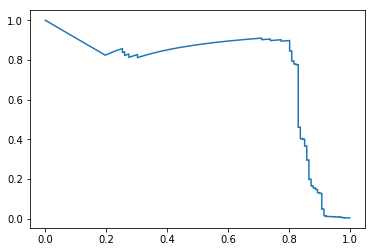

In [17]:
plt.plot(recall, precision)

# <a id='6'>6. Anomaly Detection </a>

Now it is time to start building the model .The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows

## 1. Isolation Forest Algorithm:

The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. 
- a low linear time complexity 
- a small memory requirement. 
-  good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How does it Work ?

- It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. 

Isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

## 2. Local Outlier Factor(LOF) Algorithm

The LOF algorithm is : 
- an unsupervised outlier detection method 
- it computes the local density deviation of a given data point with respect to its neighbors. 
- Outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [29]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X_train_valid),random_state=0, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1, random_state=0) 
   
}


In [ ]:
n_outliers = len(X_train_valid)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_test)
        scores_prediction = clf.negative_outlier_factor_
        score = - score_sample(X_test)
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X_test)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X_test)
        y_pred = clf.predict(X_train_valid)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    print(y_pred.shape)
    print(y_test.shape)

/home/wafa/bin/anaconda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/home/wafa/bin/anaconda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/wafa/bin/anaconda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



(198277,)
(85118,)


/home/wafa/bin/anaconda/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



(85118,)
(85118,)


/home/wafa/bin/anaconda/lib/python3.6/site-packages/sklearn/svm/classes.py:1175: DeprecationWarning:

The random_state parameter is deprecated and will be removed in version 0.22.

